# Task 2: Decision Trees for Human Activity Recognition

In this notebook, we answered the following questions:

1. Use Sklearn Library to train Decision Tress. **[1.5 marks]**
   - Train a decision tree model using the raw accelerometer data. Report the accuracy, precision, recall and confusion matrix of the model.
   - Train a decision tree model using the features obtained by TSFEL. Report the accuracy, precision, recall and confusion matrix of the model.
   - Train a decision tree model using the features provided in the dataset. Report the accuracy, precision, recall and confusion matrix of the model.
   - Compare the results of the three models. Which model do you think is better?
2. Train Decision Tree with varying depths (2-8) using all above 3 methods. Plot the accuracy of the model on test data vs the depth of the tree. **[1 marks]**
3. Are there any participants/ activitivies where the Model performace is bad? If Yes, Why? **[0.5 mark]**



### Imports

In [148]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from MakeDataset import X_train, X_test, y_train, y_test
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from MakeDataset import X_train, X_test, y_train, y_test
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score
from tqdm import tqdm

## 1. Use Sklearn Library to Train Decision Trees. [1.5 marks]



### Decision Tree using raw accelerometer data

- We have 30 subjects, each performing 6 activities. The accelerometer time series data is obtained by calling the file "MakeDataset.py".
- For each individual subject and activity, the time series data consists of 500 timesteps with 3 features (accelerometer data in x, y, z directions).
- To flatten the data, the time series is reshaped into 1500 features (500 timesteps * 3 features) for each subject and activity, with one activity label. 
- A Decision Tree Classifier is trained on this flattened data, and the decision tree is visualized.
- The decision tree is quite large and complex, but it shows how the classifier is able to distinguish between the different activities nevertheless.


In [ ]:

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Reshape the data to flatten the time-series dimension
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat.shape}")
print(f"X_test_flat shape: {X_test_flat.shape}")

X_train shape: (126, 500, 3)
X_test shape: (54, 500, 3)
y_train shape: (126,)
y_test shape: (54,)
X_train_flat shape: (126, 1500)
X_test_flat shape: (54, 1500)


In [150]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat, y_train)
y_pred = clf.predict(X_test_flat)
depth = clf.get_depth()
print("Depth of Decision Tree:", depth)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")

Depth of Decision Tree: 8
Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 



#### Classification report

In [151]:
activities=["WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS","SITTING","STANDING","LAYING"]


# 1. Classification Report (per-class + macro/micro avg)
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=activities))

# 2. Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.4f}")

# 3. Macro Precision & Recall
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall:    {recall_macro:.4f}")


Classification Report:

                    precision    recall  f1-score   support

           WALKING       0.25      0.33      0.29         9
  WALKING_UPSTAIRS       0.38      0.33      0.35         9
WALKING_DOWNSTAIRS       0.50      0.22      0.31         9
           SITTING       0.67      0.89      0.76         9
          STANDING       0.78      0.78      0.78         9
            LAYING       1.00      1.00      1.00         9

          accuracy                           0.59        54
         macro avg       0.59      0.59      0.58        54
      weighted avg       0.59      0.59      0.58        54

Overall Accuracy: 0.5926
Macro Precision: 0.5949
Macro Recall:    0.5926


#### Visualizing the Decision Tree

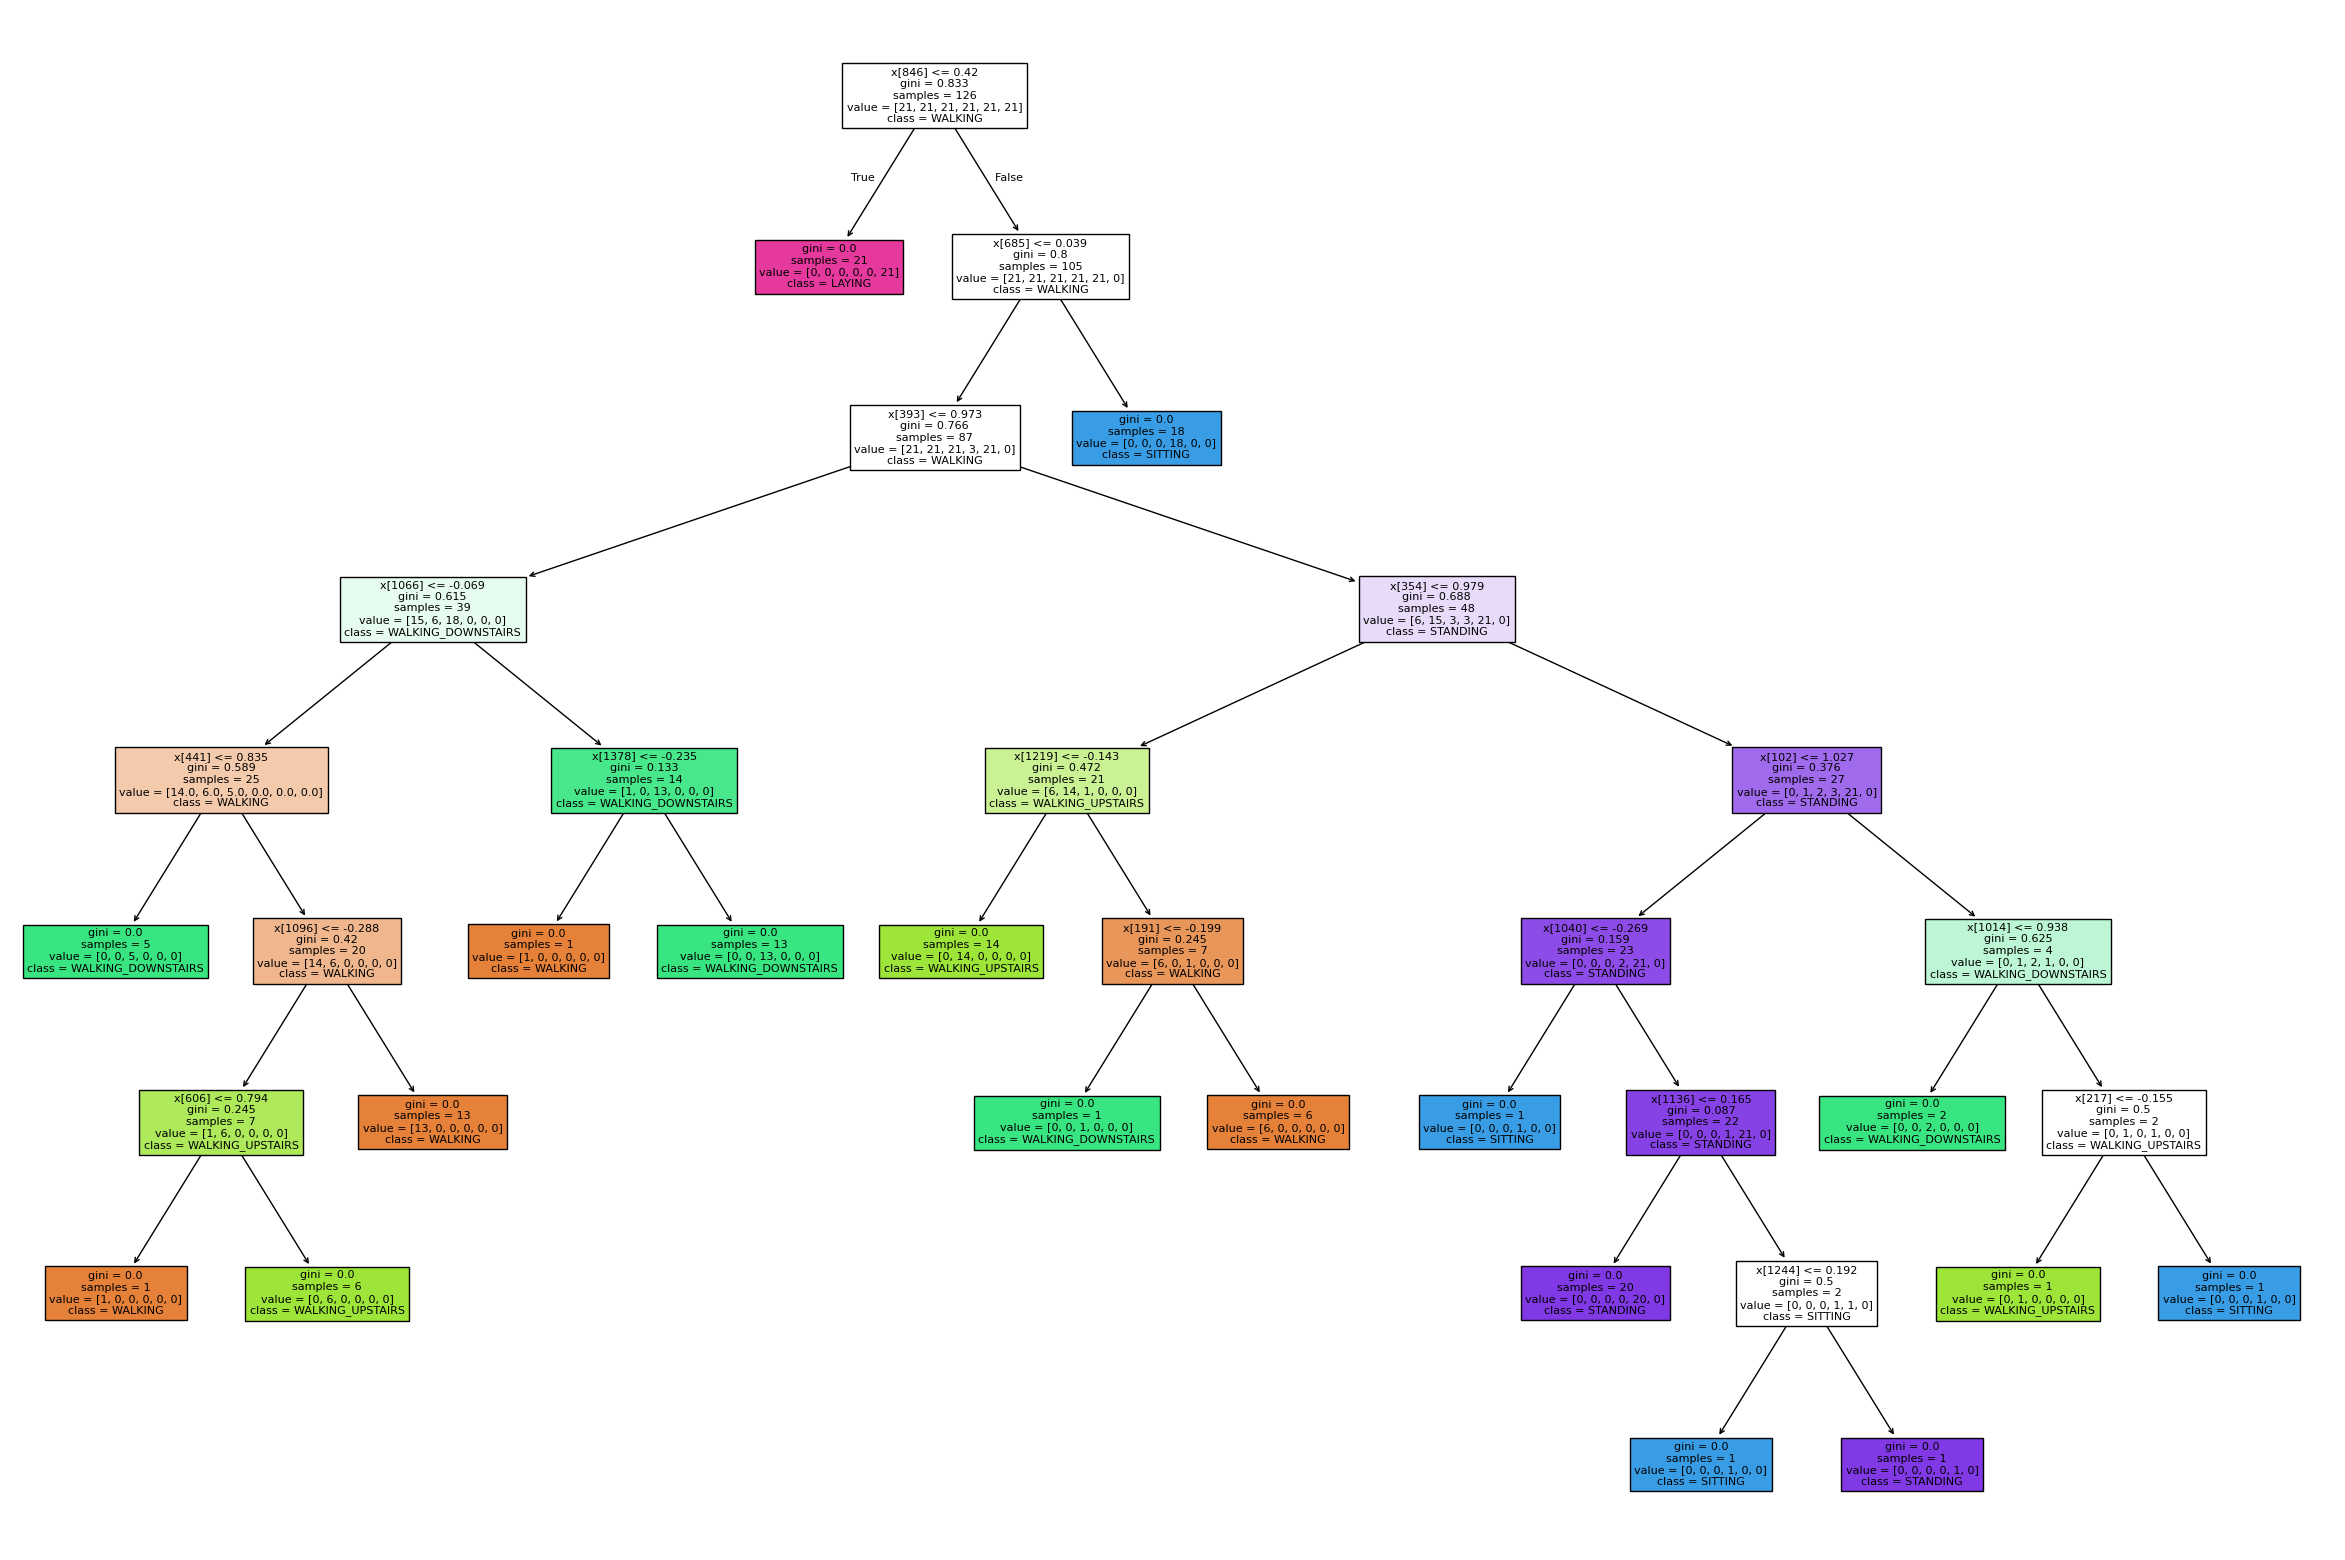

In [152]:
plt.figure(figsize=(30, 20))
plot_tree(clf, 
          filled=True,
          class_names=activities,
        )    
plt.show()


#### Confusion Matrix

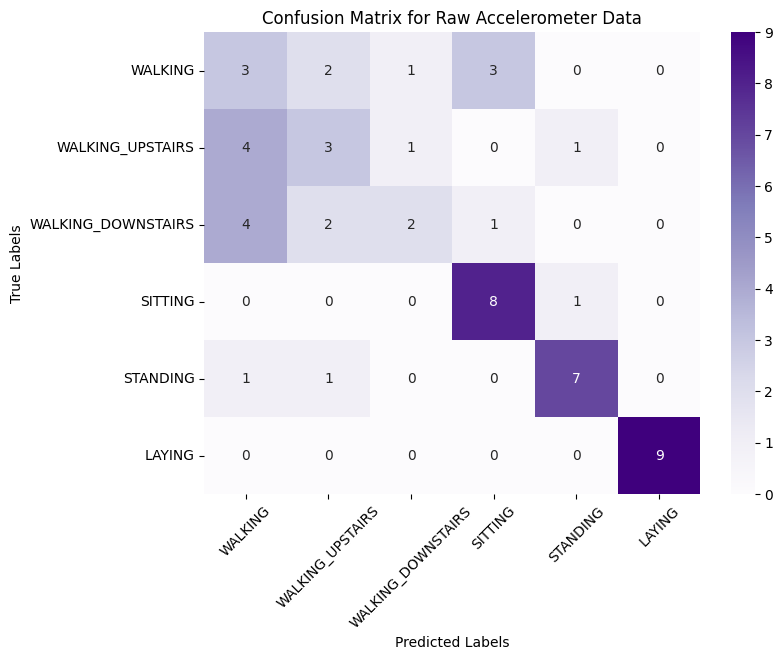

In [166]:

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', 
            xticklabels=activities, 
            yticklabels=activities)

plt.xticks(rotation=45)  
plt.yticks()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Raw Accelerometer Data')

plt.show()

### Decision Tree using TSFEL data


- Here, we are passing all features obtained by TSFEL library as input to the Decision Tree Classifier.
- These features are extracted from the raw accelerometer data using the TSFEL library.
- The features are passed to the Decision Tree Classifier, and the accuracy, precision, recall, and confusion matrix are reported.

In [179]:
def load_tsfel_dataset(base_dir, dataset_type):
    activities = ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

    data = []
    labels = []
    
    for activity in activities:
        folder_path = os.path.join(base_dir, dataset_type, activity)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.csv'):
                file_path = os.path.join(folder_path, file_name)
                df = pd.read_csv(file_path)
                
                num_timesteps, num_features = df.shape
                
                subject_data = df.values.reshape((num_timesteps, num_features))  # Shape: (500, 3)
                
                data.append(subject_data)
                labels.append(activity)
    
    data = np.array(data)  # Shape: (num_subjects, num_timesteps, num_features)
    labels = np.array(labels) 
    
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    
    return data, labels_encoded

base_dir = 'Datasets/TSFEL_3axes_allfeatures'

X_train1, y_train1 = load_tsfel_dataset(base_dir, 'Train')
X_test1, y_test1 = load_tsfel_dataset(base_dir, 'Test')

print("X_train shape:", X_train1.shape)
print("y_train shape:", y_train1.shape)
print("X_test shape:", X_test1.shape)
print("y_test shape:", y_test1.shape)

# Reshape the data to flatten the time-series dimension
X_train_flat1 = X_train1.reshape(X_train1.shape[0], -1)  # Shape: (126, 1500)
X_test_flat1 = X_test1.reshape(X_test1.shape[0], -1)  # Shape: (54, 1500)

print(f"X_train_flat shape: {X_train_flat1.shape}")
print(f"X_test_flat shape: {X_test_flat1.shape}")


X_train shape: (126, 1, 489)
y_train shape: (126,)
X_test shape: (54, 1, 489)
y_test shape: (54,)
X_train_flat shape: (126, 489)
X_test_flat shape: (54, 489)


In [180]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat1, y_train1)
depth = clf.get_depth()
print("Depth of Decision Tree:", depth)
y_pred1 = clf.predict(X_test_flat1)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")

Depth of Decision Tree: 5
Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 



#### Classification report

In [181]:


# 1. Classification Report (per-class + macro/micro avg)
print("Classification Report:\n")
print(classification_report(y_test1, y_pred1, target_names=activities))

# 2. Overall Accuracy
accuracy = accuracy_score(y_test1, y_pred1)
print(f"Overall Accuracy: {accuracy:.4f}")

# 3. Macro Precision & Recall
precision_macro = precision_score(y_test1, y_pred1, average='macro')
recall_macro = recall_score(y_test1, y_pred1, average='macro')

print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall:    {recall_macro:.4f}")



Classification Report:

                    precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00         9
  WALKING_UPSTAIRS       1.00      0.78      0.88         9
WALKING_DOWNSTAIRS       0.82      1.00      0.90         9
           SITTING       1.00      1.00      1.00         9
          STANDING       0.80      0.89      0.84         9
            LAYING       0.88      0.78      0.82         9

          accuracy                           0.91        54
         macro avg       0.92      0.91      0.91        54
      weighted avg       0.92      0.91      0.91        54

Overall Accuracy: 0.9074
Macro Precision: 0.9155
Macro Recall:    0.9074


#### Visualizing the Decision Tree

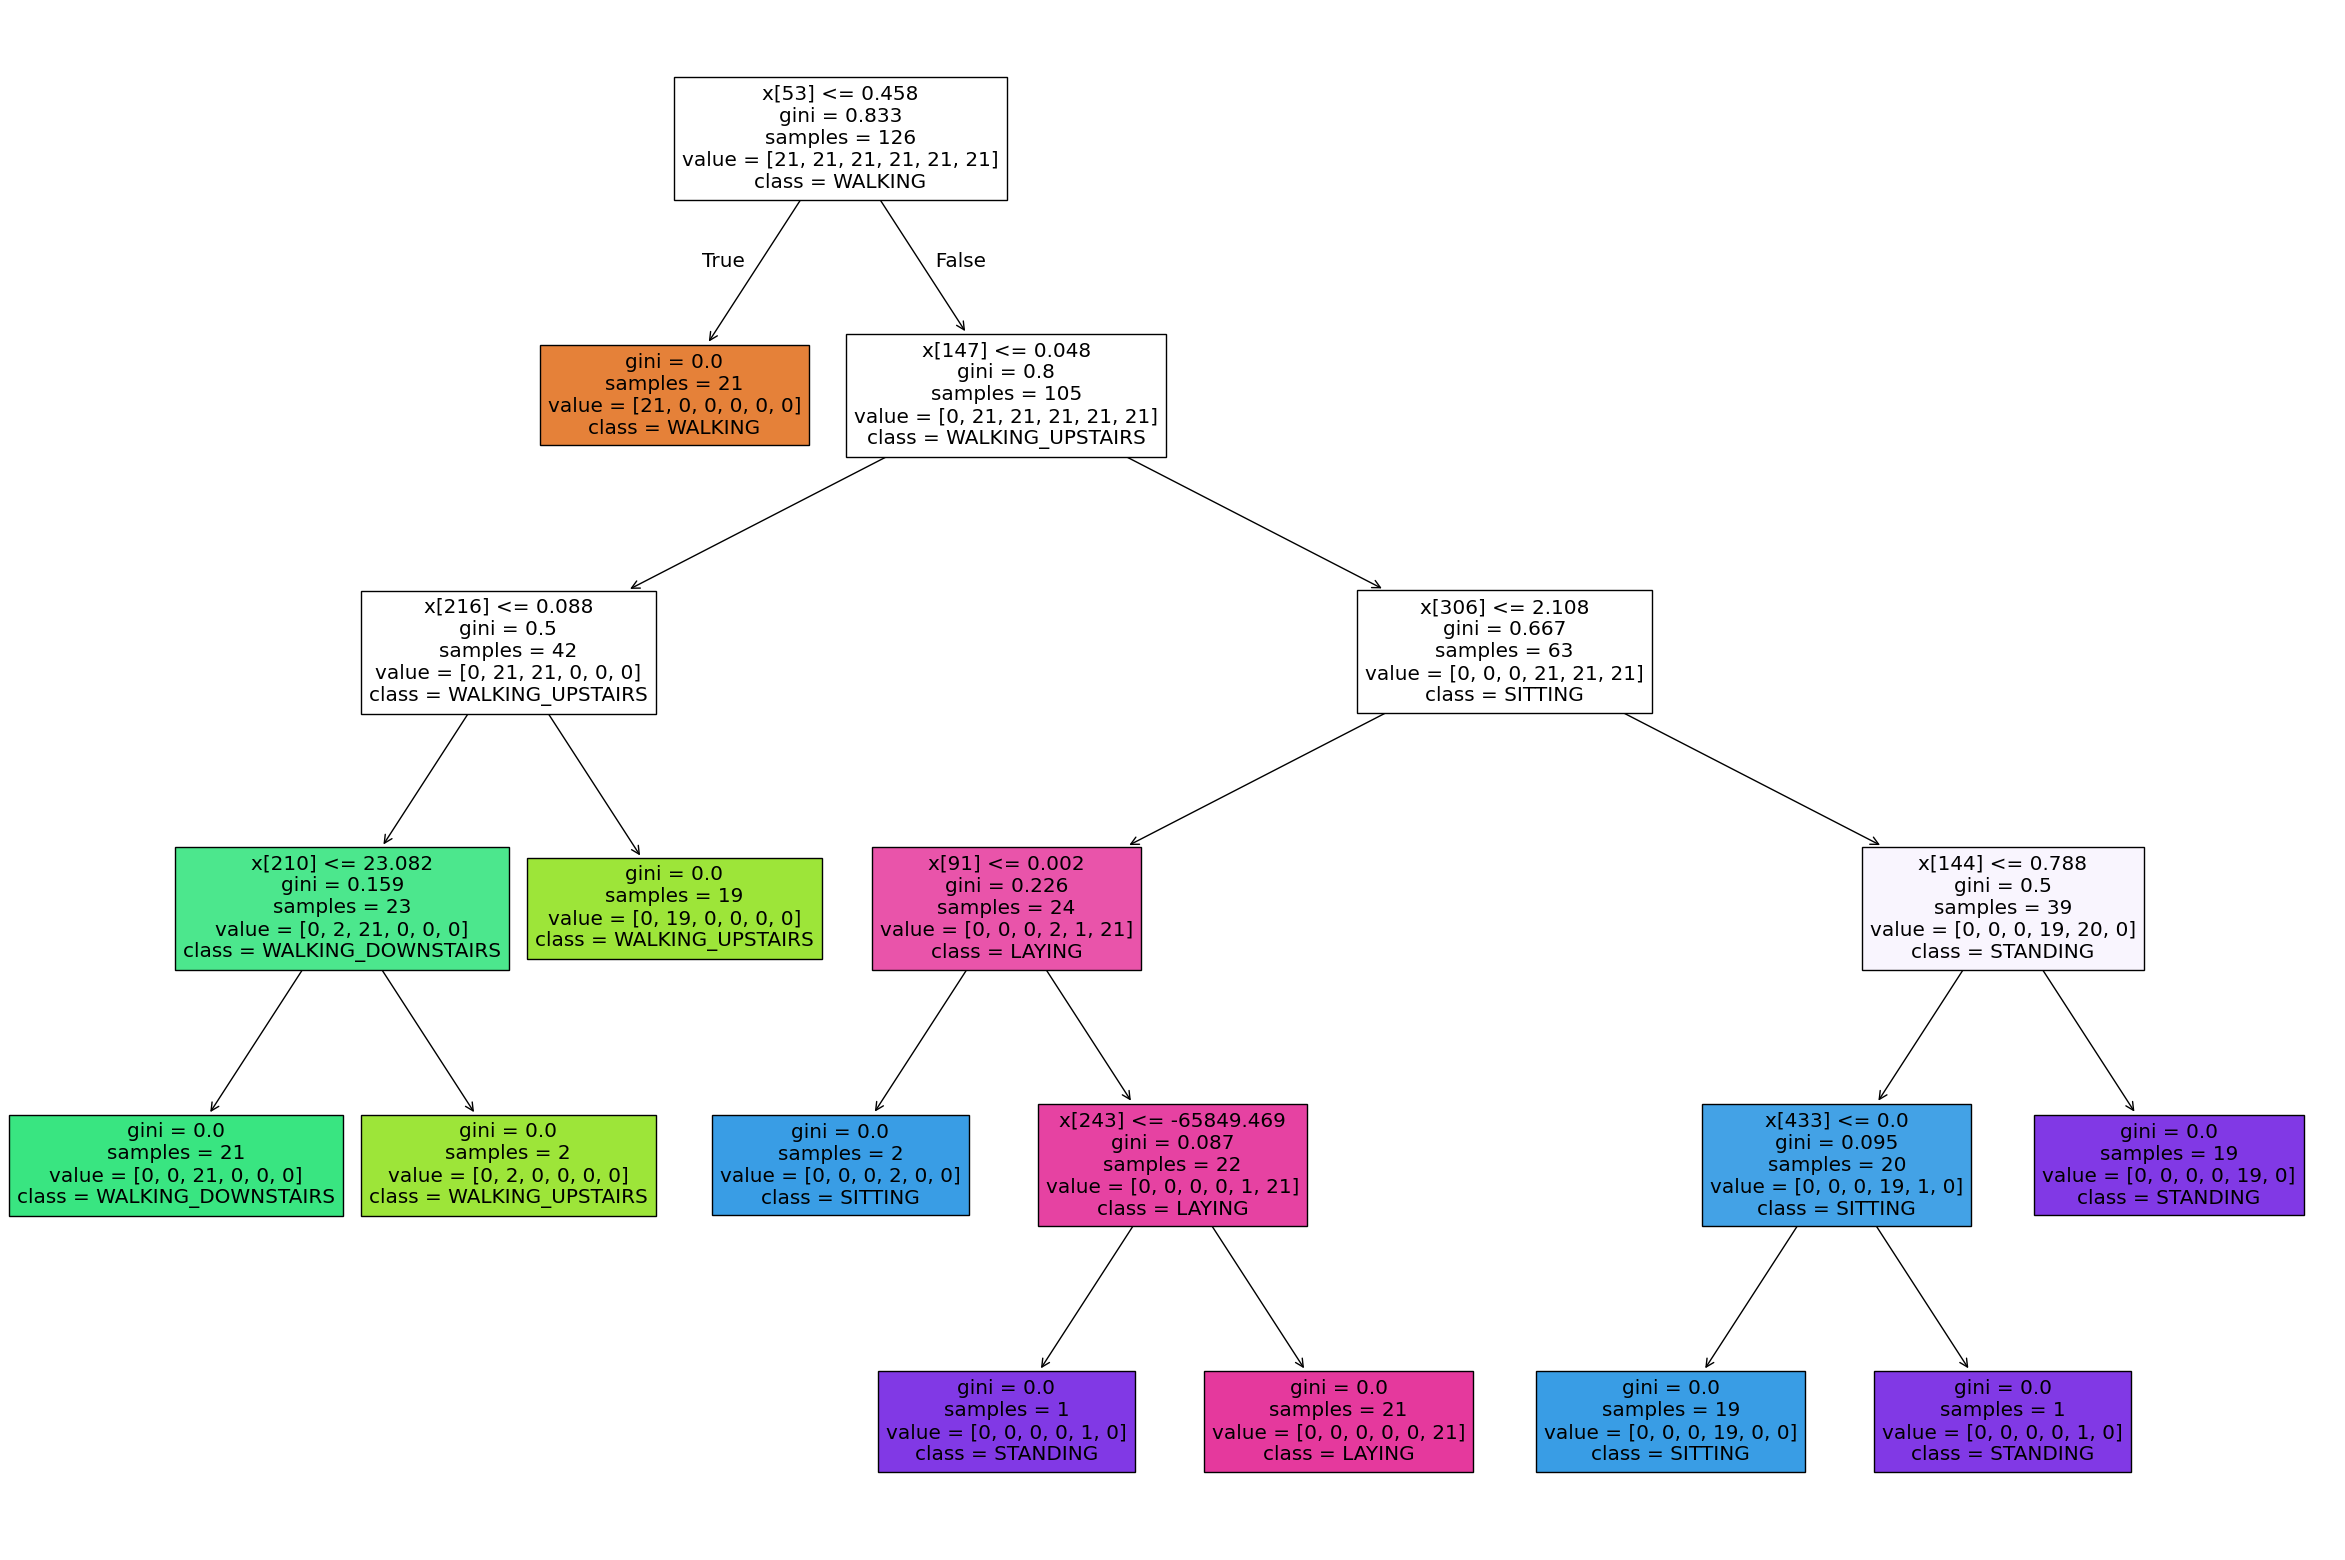

In [182]:
plt.figure(figsize=(30, 20))
plot_tree(clf, 
          filled=True, 
          class_names=activities,
          )    

plt.show()


#### Confusion Matrix

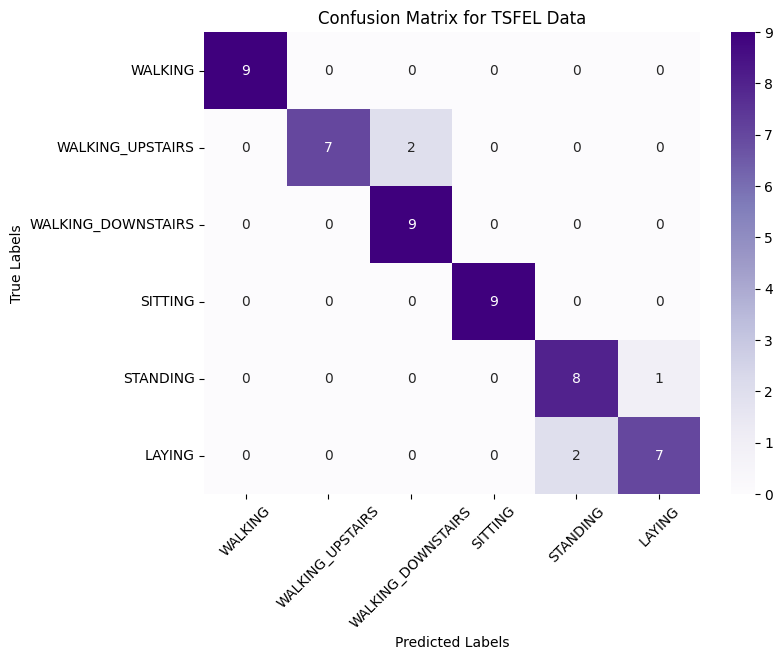

In [183]:
conf_matrix = confusion_matrix(y_test1, y_pred1)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', 
            xticklabels=activities, 
            yticklabels=activities)

plt.xticks(rotation=45)  
plt.yticks()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for TSFEL Data')

plt.show()


### Decision Tree using UCI HAR Dataset features

- A Decision Tree Classifier was trained on the flattened version of data obtained from MakeHARdataset file, trained on n_features*n_subjects samples. The accuracy, precision, recall, and confusion matrix were reported for the model.

In [ ]:
from MakeHARDataset import X_train, X_test, y_train, y_test
X_train2 = X_train
X_test2 = X_test
y_test2 = y_test
y_train2 = y_train
print(f"X_train shape: {X_train2.shape}") # Corresponds to shape(num_subjects * num_activities, num_timesteps, num_features)
print(f"X_test shape: {X_test2.shape}") # Corresponds to shape(num_subjects * num_activities, num_timesteps, num_features)
print(f"y_train shape: {y_train2.shape}") # Corresponds to shape (num_subjects * num_activities)
print(f"y_test shape: {y_test2.shape}") # Corresponds to shape (num_subjects * num_activities)

X_train_flat2 = X_train2.reshape(X_train2.shape[0], -1) 
X_test_flat2 = X_test2.reshape(X_test2.shape[0], -1)  

print(f"X_train_flat shape: {X_train_flat2.shape}")
print(f"X_test_flat shape: {X_test_flat2.shape}")


X_train shape: (7352, 561)
X_test shape: (2947, 561)
y_train shape: (7352,)
y_test shape: (2947,)
X_train_flat shape: (7352, 561)
X_test_flat shape: (2947, 561)


In [ ]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train_flat2, y_train2)
y_pred2 = clf.predict(X_test_flat2)
print("Decision Tree Hyperparameters:\n", clf.get_params(), "\n")

Decision Tree Hyperparameters:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 0, 'splitter': 'best'} 



#### Classification report

In [ ]:


# 1. Classification Report (per-class + macro/micro avg)
print("Classification Report:\n")
print(classification_report(y_test2, y_pred2, target_names=activities))

# 2. Overall Accuracy
accuracy = accuracy_score(y_test2, y_pred2)
print(f"Overall Accuracy: {accuracy:.4f}")

# 3. Macro Precision & Recall
precision_macro = precision_score(y_test2, y_pred2, average='macro')
recall_macro = recall_score(y_test2, y_pred2, average='macro')

print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall:    {recall_macro:.4f}")


Classification Report:

                    precision    recall  f1-score   support

           WALKING       0.82      0.89      0.85       496
  WALKING_UPSTAIRS       0.80      0.80      0.80       471
WALKING_DOWNSTAIRS       0.90      0.82      0.86       420
           SITTING       0.84      0.76      0.80       491
          STANDING       0.80      0.86      0.83       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.86      2947
         macro avg       0.86      0.85      0.86      2947
      weighted avg       0.86      0.86      0.86      2947

Overall Accuracy: 0.8585
Macro Precision: 0.8594
Macro Recall:    0.8547


#### Visualizing the Decision Tree

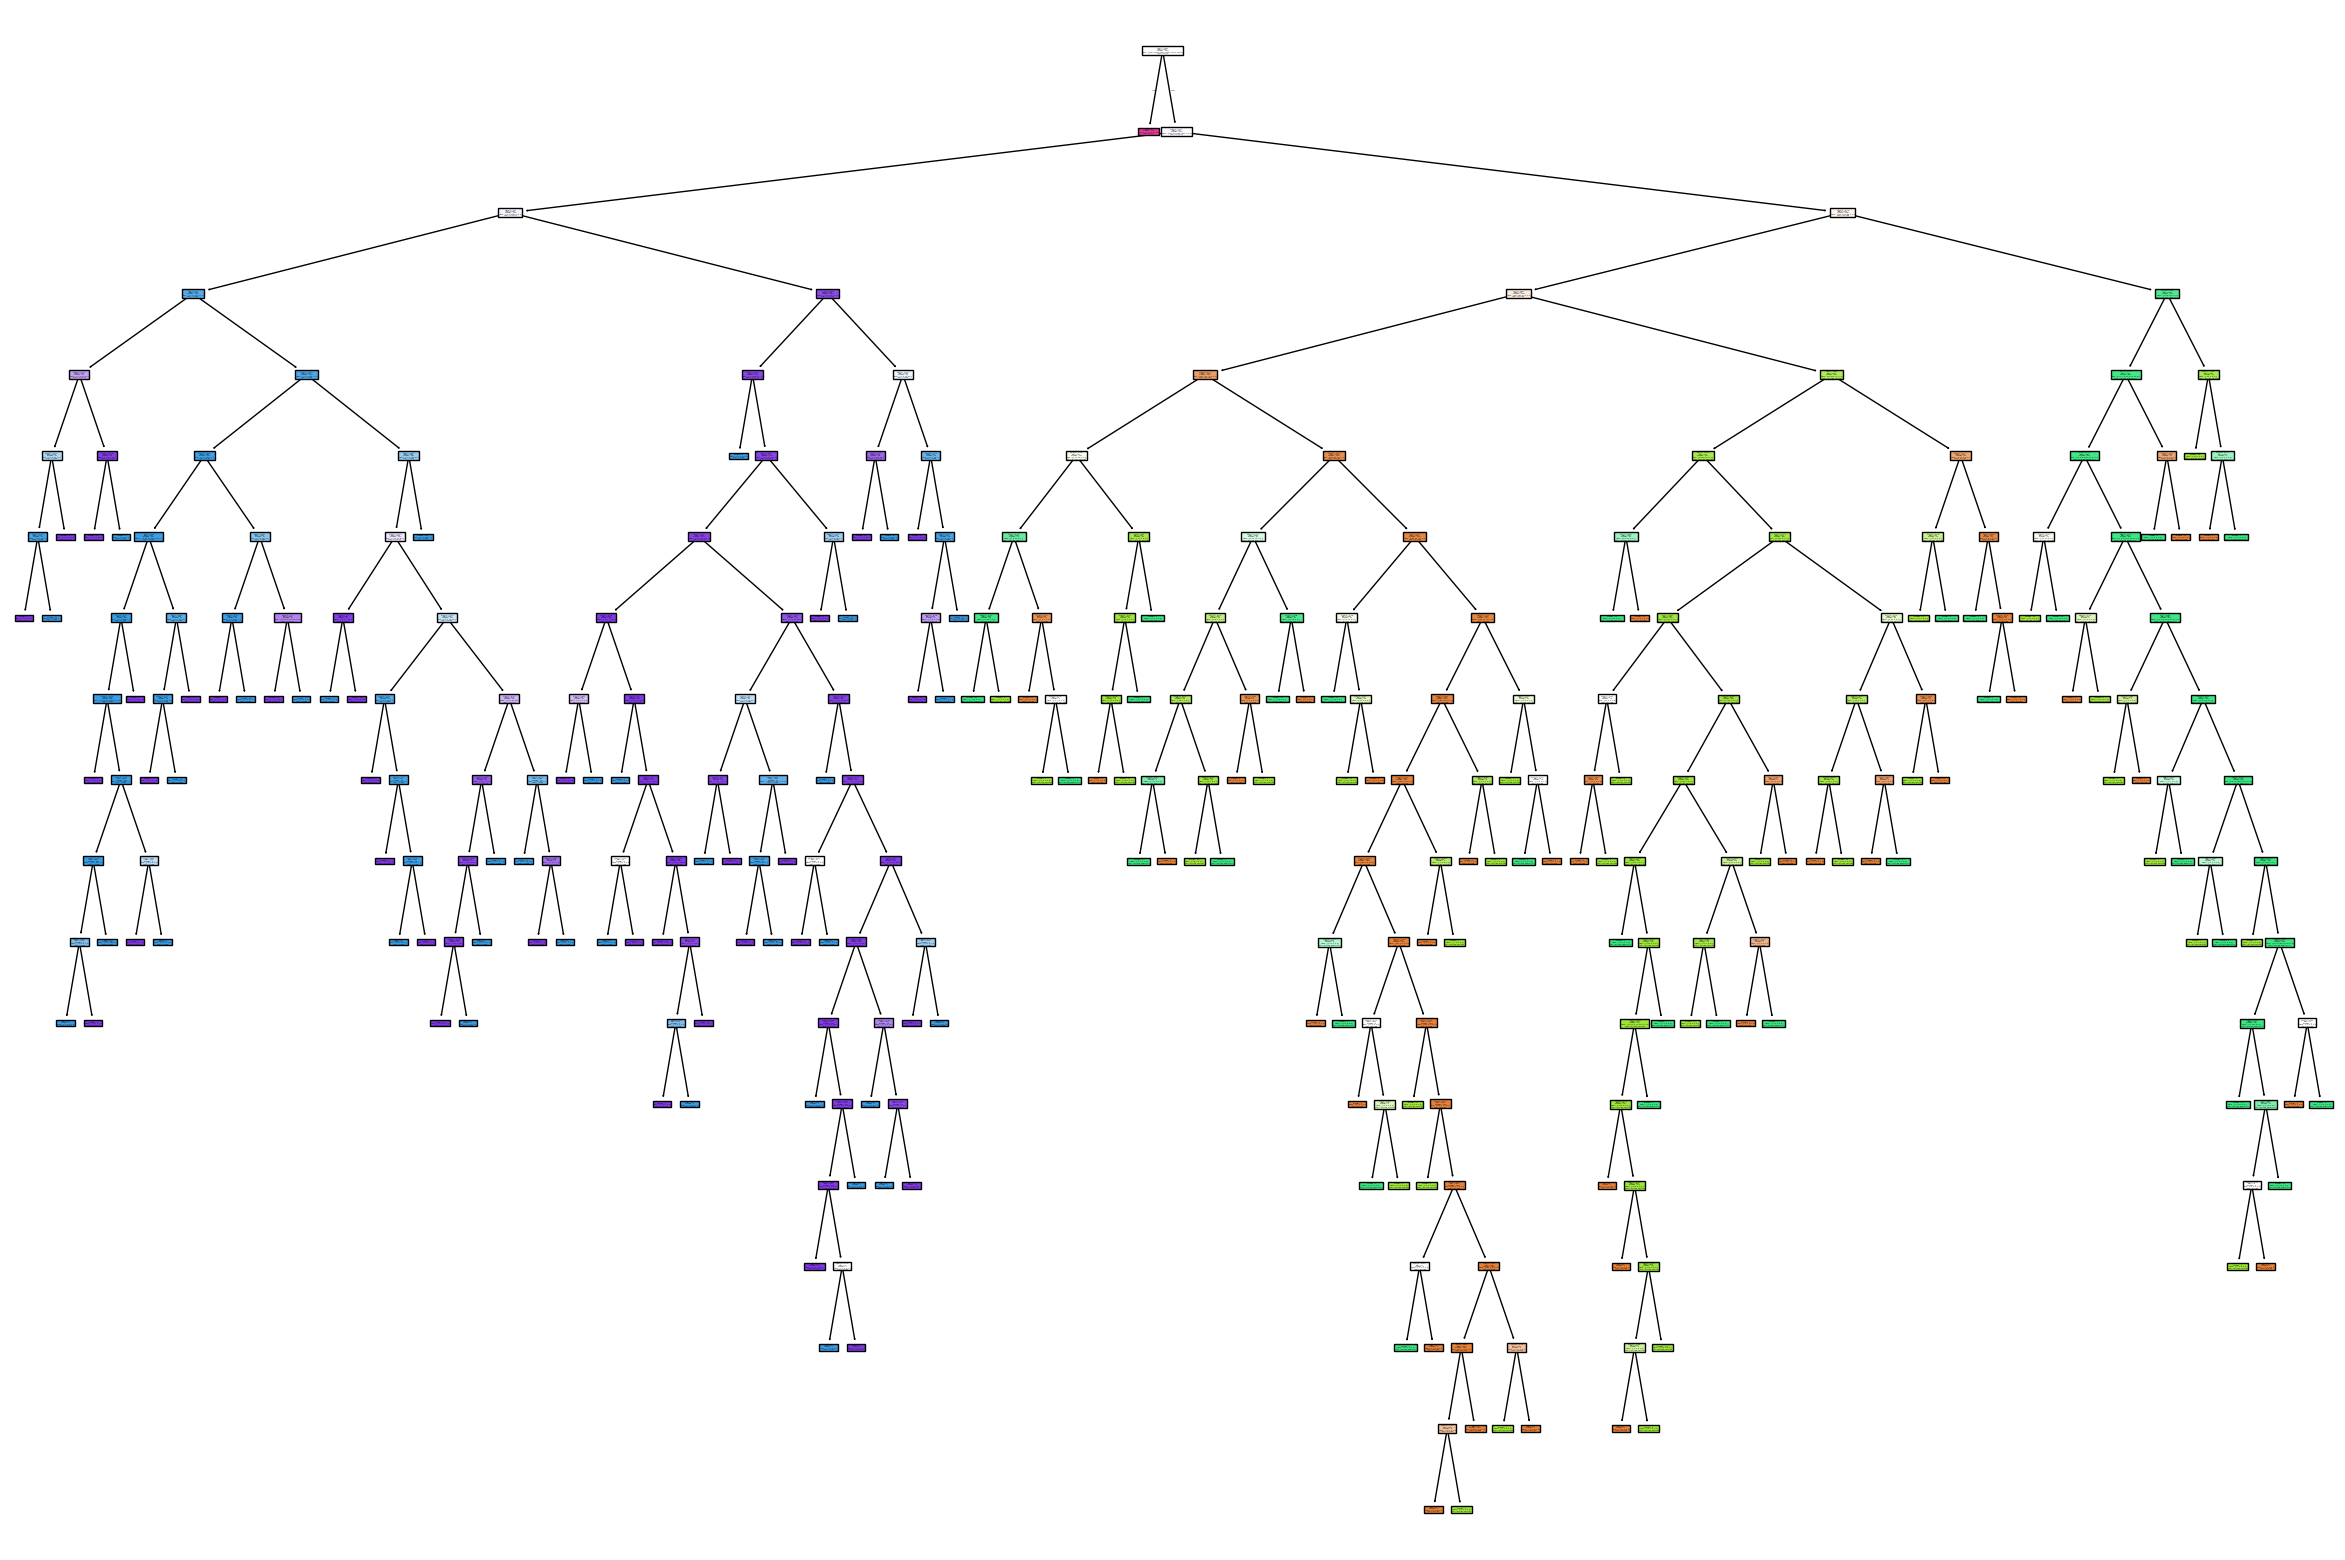

In [ ]:
plt.figure(figsize=(30, 20))
plot_tree(clf, 
          filled=True, 
          class_names=activities,
          )    

plt.show()


#### Confusion Matrix

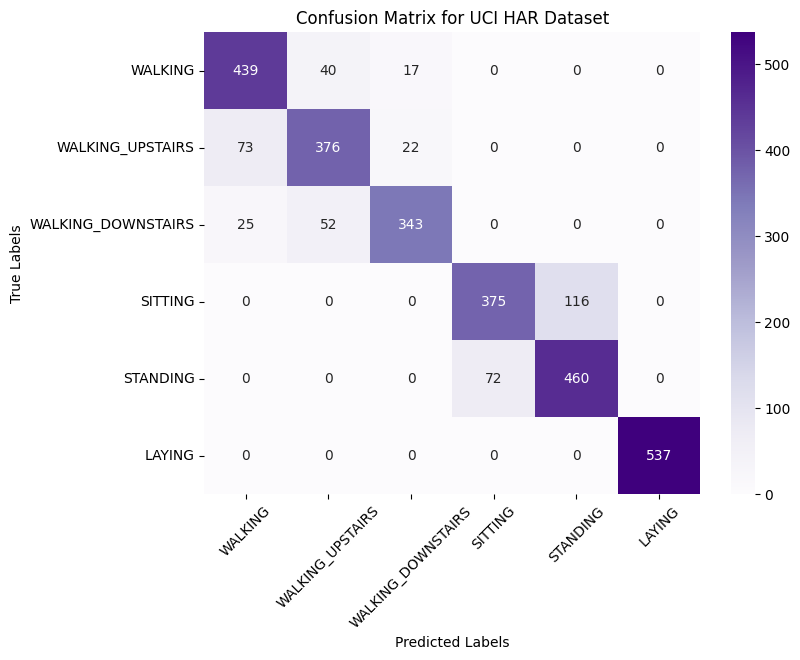

In [ ]:
conf_matrix = confusion_matrix(y_test2, y_pred2)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', 
            xticklabels=activities, 
            yticklabels=activities)

plt.xticks(rotation=45)  
plt.yticks()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for UCI HAR Dataset')

plt.show()


### Compare the results of the three models. Which model do you think is better?

Here is the summary of the results of all the models

| Model | Accuracy | Precision | Recall |
| --- | --- | --- | --- |
| Raw Accelerometer Data | 59.49% | 59.26% | 59.26% |
| TSFEL Features | 90.74% | 91.55% | 90.74% |
| UCI HAR Dataset Features | 85.85% | 85.94% | 85.47% |

From these results we can conclude that the decision tree model using the TSFEL features and the UCI HAR dataset features performs better than the model using raw accelerometer data. The model using the TSFEL feature has higher accuracy, precision and recall as compared to the model using UCI HAR dataset. Therefore, the model using the TSFEL features is the best among the three models.



## 2. Accuracy vs Depth of Decision Tree

### For raw accelerometer data

Hyperparameters kept constant across different depths:
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
random_state: 0
splitter: best


Depth: 2, Train Accuracy: 54.50%, Test Accuracy: 53.10%
Depth: 3, Train Accuracy: 78.79%, Test Accuracy: 72.24%
Depth: 4, Train Accuracy: 89.83%, Test Accuracy: 80.96%
Depth: 5, Train Accuracy: 92.04%, Test Accuracy: 83.85%
Depth: 6, Train Accuracy: 94.34%, Test Accuracy: 85.51%
Depth: 7, Train Accuracy: 95.96%, Test Accuracy: 86.39%
Depth: 8, Train Accuracy: 97.33%, Test Accuracy: 87.07%


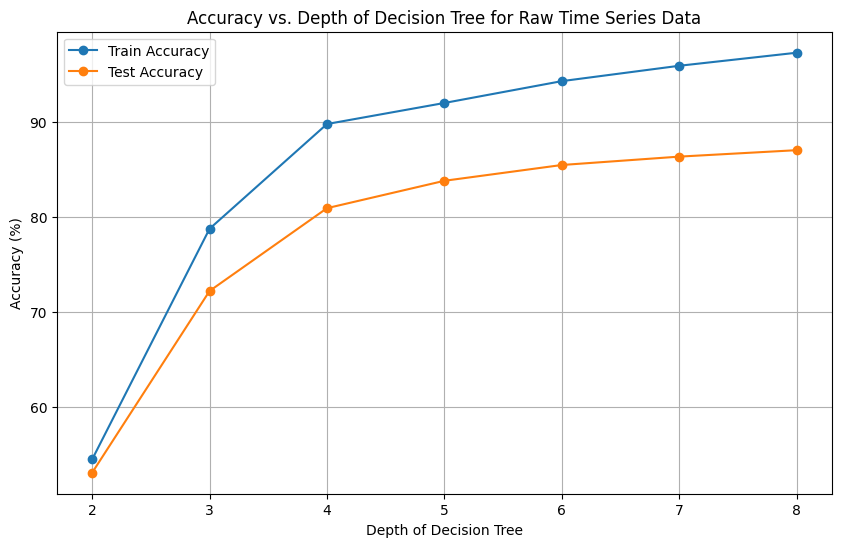

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Shape: (126, 1500)
X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Shape: (54, 1500)

depths = range(2, 9)
train_accuracies = []
test_accuracies = []
clf_default = DecisionTreeClassifier(random_state=0)
default_params = clf_default.get_params()

default_params.pop('max_depth')

print("Hyperparameters kept constant across different depths:")
for param, value in default_params.items():
    print(f"{param}: {value}")

print("\n")

for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    clf.fit(X_train_flat, y_train)
    
    y_train_pred = clf.predict(X_train_flat)
    y_test_pred = clf.predict(X_test_flat)
    
    train_accuracy = accuracy_score(y_train, y_train_pred) * 100
    test_accuracy = accuracy_score(y_test, y_test_pred) * 100
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    print(f"Depth: {depth}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(depths, test_accuracies, label='Test Accuracy', marker='o')
plt.title('Accuracy vs. Depth of Decision Tree for Raw Time Series Data')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Accuracy (%)')
plt.xticks(depths)
plt.legend()
plt.grid(True)
plt.show()


### For TSEFL feature data

Hyperparameters kept constant across different depths:
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
random_state: 0
splitter: best


Depth: 2, Train Accuracy: 50.00%, Test Accuracy: 50.00%
Depth: 3, Train Accuracy: 80.95%, Test Accuracy: 75.93%
Depth: 4, Train Accuracy: 98.41%, Test Accuracy: 85.19%
Depth: 5, Train Accuracy: 100.00%, Test Accuracy: 83.33%
Depth: 6, Train Accuracy: 100.00%, Test Accuracy: 83.33%
Depth: 7, Train Accuracy: 100.00%, Test Accuracy: 83.33%
Depth: 8, Train Accuracy: 100.00%, Test Accuracy: 83.33%


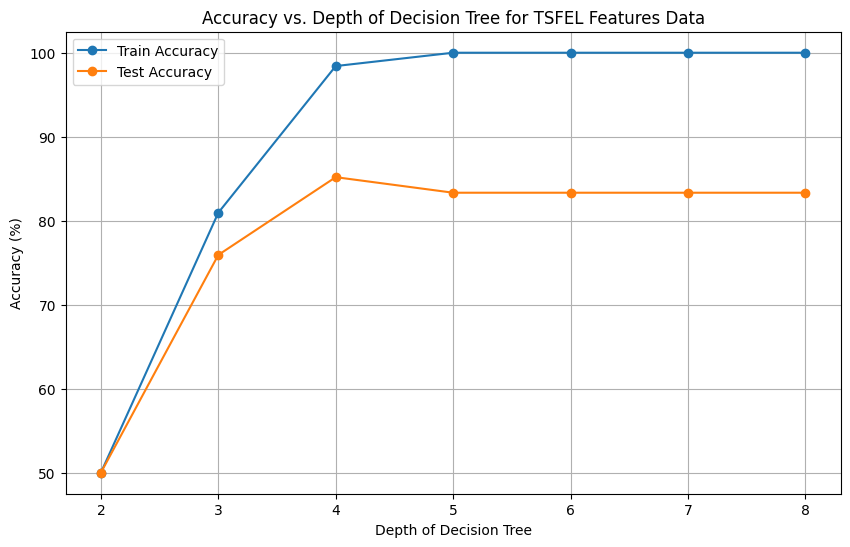

In [178]:
base_dir = 'Combined/TSFEL_3axes_allfeatures'  

X_train1, y_train1 = load_tsfel_dataset(base_dir, 'Train')
X_test1, y_test1 = load_tsfel_dataset(base_dir, 'Test')

X_train_flat1 = X_train1.reshape(X_train1.shape[0], -1)  
X_test_flat1 = X_test1.reshape(X_test1.shape[0], -1) 

depths = range(2, 9)

train_accuracies = []
test_accuracies = []

clf_default = DecisionTreeClassifier(random_state=0)
default_params = clf_default.get_params()

default_params.pop('max_depth')

print("Hyperparameters kept constant across different depths:")
for param, value in default_params.items():
    print(f"{param}: {value}")

print("\n")

for depth in depths:
    clf= DecisionTreeClassifier(max_depth=depth, random_state=0)
    clf.fit(X_train_flat1, y_train1)

    y_train_pred1 = clf.predict(X_train_flat1)
    y_test_pred1 = clf.predict(X_test_flat1)

    train_accuracy1 = accuracy_score(y_train1, y_train_pred1) * 100
    test_accuracy1 = accuracy_score(y_test1, y_test_pred1) * 100

    train_accuracies.append(train_accuracy1)
    test_accuracies.append(test_accuracy1)

    print(f"Depth: {depth}, Train Accuracy: {train_accuracy1:.2f}%, Test Accuracy: {test_accuracy1:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(depths, test_accuracies, label='Test Accuracy', marker='o')
plt.title('Accuracy vs. Depth of Decision Tree for TSFEL Features Data')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Accuracy (%)')
plt.xticks(depths)
plt.legend()
plt.grid(True)
plt.show()


### For HAR data

Hyperparameters kept constant across different depths:
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
monotonic_cst: None
random_state: 0
splitter: best


Depth: 2, Train Accuracy: 54.50%, Test Accuracy: 53.10%
Depth: 3, Train Accuracy: 78.79%, Test Accuracy: 72.24%
Depth: 4, Train Accuracy: 89.83%, Test Accuracy: 80.96%
Depth: 5, Train Accuracy: 92.04%, Test Accuracy: 83.85%
Depth: 6, Train Accuracy: 94.34%, Test Accuracy: 85.51%
Depth: 7, Train Accuracy: 95.96%, Test Accuracy: 86.39%
Depth: 8, Train Accuracy: 97.33%, Test Accuracy: 87.07%


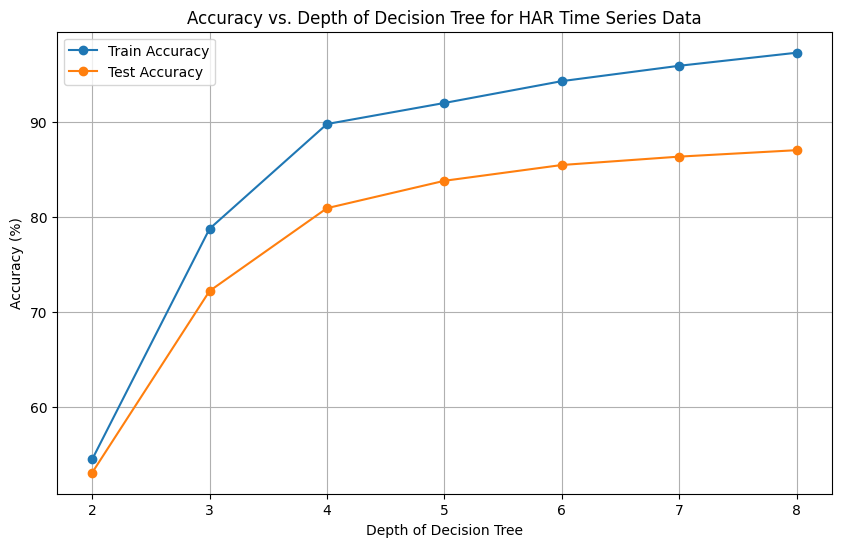

In [ ]:
# Reshape the data to flatten the time-series dimension
X_train_flat2 = X_train2.reshape(X_train2.shape[0], -1)  # Shape: (126, 1500)
X_test_flat2 = X_test2.reshape(X_test2.shape[0], -1)  # Shape: (54, 1500)

depths = range(2, 9)

train_accuracies = []
test_accuracies = []

clf_default = DecisionTreeClassifier(random_state=0)
default_params = clf_default.get_params()

default_params.pop('max_depth')

print("Hyperparameters kept constant across different depths:")
for param, value in default_params.items():
    print(f"{param}: {value}")

print("\n")

for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    clf.fit(X_train_flat2, y_train2)

    y_train_pred2 = clf.predict(X_train_flat2)
    y_test_pred2 = clf.predict(X_test_flat2)

    train_accuracy2 = accuracy_score(y_train2, y_train_pred2) * 100
    test_accuracy2 = accuracy_score(y_test2, y_test_pred2) * 100

    train_accuracies.append(train_accuracy2)
    test_accuracies.append(test_accuracy2)

    print(f"Depth: {depth}, Train Accuracy: {train_accuracy2:.2f}%, Test Accuracy: {test_accuracy2:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(depths, test_accuracies, label='Test Accuracy', marker='o')
plt.title('Accuracy vs. Depth of Decision Tree for HAR Time Series Data')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Accuracy (%)')
plt.xticks(depths)
plt.legend()
plt.grid(True)
plt.show()

## 3. Are there any participants/ activitivies where the Model performace is bad? If Yes, Why? [0.5 mark]

### Datset - Raw Accelerometer Data:
This dataset gives poor performance overall compared to the featurised datasets. Activities like WALKING (precision=0.25, f1=0.33) and WALKING_DOWNSTAIRS (recall=0.22) are severely misclassified. Static activities such as sitting, standing, and laying are handled reasonably. The model struggles to separate dynamic activities (walking, walking upstairs, walking downstairs). From the confusion matrix, we see confusion across these three activities. This likely occurs because the raw features do not capture motion patterns well and due to overlapping signal patterns between these activities.   

### Dataset - TSFEL Data:
This model performs the best overall. The highest accuracy is observed for WALKING and SITTING, where there are no errors. However, the model struggles with walking upstairs vs downstairs. This is also evident from the graphs which we saw in task 1, where walking upstairs and downstairs had a visually similar graph. Same seems to be the case in standing and laying.

### Dataset - UCI HAR
The UCI HAR feature set also performs well but shows some misclassifications in walking vs walking upstairs/downstairs, as these have visually similar feature patterns. Some errors are also observed between sitting and standing. No errors in classification were observed in laying.

### Overall Conclusion
From both of the above featurised data, we can see that the model has no errors in classifying between static and dynamic activities.

In general all the models have difficulty in classifying walking upstairs and walking downstairs (or the dynamic activities). This is because the features of these activities are visually similar and hence the model has difficulty in distinguishing between them. The model performs better in classifying static activities like sitting, standing and laying.